In [1]:
import matplotlib
matplotlib.use('Agg')

import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

params = {
   'axes.labelsize': 14,
   'font.size': 14,
   'font.family': ' DejaVu Sans',
   'legend.fontsize': 20,
   'xtick.labelsize': 20,
   'ytick.labelsize': 20,
   'axes.labelsize': 25,
   'axes.titlesize': 25,
   'text.usetex': False,
   'figure.figsize': [12, 12]
}
matplotlib.rcParams.update(params)


import ase.io
from ase.io.trajectory import Trajectory
from ase.io import extxyz
from ase.calculators.emt import EMT
from ase.build import fcc100, add_adsorbate, molecule
from ase.constraints import FixAtoms
from ase.optimize import LBFGS
from ase.visualize.plot import plot_atoms
from ase import Atoms
from IPython.display import Image

In [2]:
videos_dir = "videos/"
os.makedirs(videos_dir, exist_ok=True)

config = {
    "num_procs": 1,
    "fps": 30,
}

## Understanding the data

We use the Atomic Simulation Environment (ASE) to interact with our data. This notebook will provide you with some intuition on what the data looks like, how to visualize it, and the specific properties that are passed on to our models.

### Generating sample data
For simplicity, we generate sample data in the same format as the OC20 dataset. A toy relaxation (or trajectory) of propane (C3H8) on a copper (Cu) surface is used with a classical-like potential (EMT). Unlike DFT, EMT is extremely fast but limited in accuracy and applicability to certain elements, making it great for demos and tests. You are free to explore alternative systems below, however, you may skip the data construction and move on to "Reading a trajectory".

In [8]:
###DATA GENERATION - FEEL FREE TO SKIP###

adslab = fcc100("Cu", size=(3, 3, 3))
adsorbate = molecule("C3H8")
add_adsorbate(adslab, adsorbate, 3, offset=(1, 1)) # adslab = adsorbate + slab

# tag all slab atoms below surface as 0, surface as 1, adsorbate as 2
tags = np.zeros(len(adslab))
tags[18:27] = 1
tags[27:] = 2

adslab.set_tags(tags)

# Fixed atoms are prevented from moving during a structure relaxation. We fix all slab atoms beneath the surface 
cons= FixAtoms(indices=[atom.index for atom in adslab if (atom.tag == 0)])
adslab.set_constraint(cons)
adslab.center(vacuum=13.0, axis=2)
adslab.set_pbc(True)
adslab.set_calculator(EMT())

os.makedirs('data', exist_ok=True)

# Define structure optimizer - LBFGS. Run for 100 steps, or if the max force on all atoms (fmax) is below 0 ev/A.
# fmax is typically set to 0.01-0.05 eV/A, for this demo however we run for the full 100 steps.

dyn = LBFGS(adslab, trajectory="data/toy_c3h8_relax.traj")
dyn.run(fmax=0, steps=100)

traj = ase.io.read("data/toy_c3h8_relax.traj", ":")

# convert traj format to extxyz format (used by OC20 dataset)
columns = (['symbols','positions', 'move_mask', 'tags'])
with open('data/toy_c3h8_relax.extxyz','w') as f:
    extxyz.write_xyz(f, traj, columns=columns)
    
os.system("rm data/toy_c3h8_relax.traj")

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 12:47:29       15.804700*       6.7764
LBFGS:    1 12:47:29       12.190607*       4.3232
LBFGS:    2 12:47:29       10.240169*       2.2655
LBFGS:    3 12:47:29        9.779223*       0.9372
LBFGS:    4 12:47:29        9.671525*       0.7702
LBFGS:    5 12:47:29        9.574461*       0.6635
LBFGS:    6 12:47:29        9.537502*       0.5718
LBFGS:    7 12:47:29        9.516673*       0.4466
LBFGS:    8 12:47:29        9.481330*       0.4611
LBFGS:    9 12:47:29        9.462255*       0.2931
LBFGS:   10 12:47:29        9.448937*       0.2490
LBFGS:   11 12:47:29        9.433813*       0.2371
LBFGS:   12 12:47:29        9.418884*       0.2602
LBFGS:   13 12:47:29        9.409649*       0.2532
LBFGS:   14 12:47:30        9.404838*       0.1624
LBFGS:   15 12:47:30        9.401753*       0.1823
LBFGS:   16 12:47:30        9.397314*       0.2592
LBFGS:   17 12:47:30        9.3879

/usr/local/Caskroom/miniforge/base/envs/ocp-models/lib/python3.8/site-packages/ase/io/extxyz.py:301: UserWarning: Skipping unhashable information adsorbate_info
  warnings.warn('Skipping unhashable information '


0

### Reading a trajectory

In [9]:
identifier = "toy_c3h8_relax.extxyz"
traj = ase.io.read("data/%s" % identifier, index=":")

### Viewing a trajectory

<AxesSubplot:title={'center':'final'}>

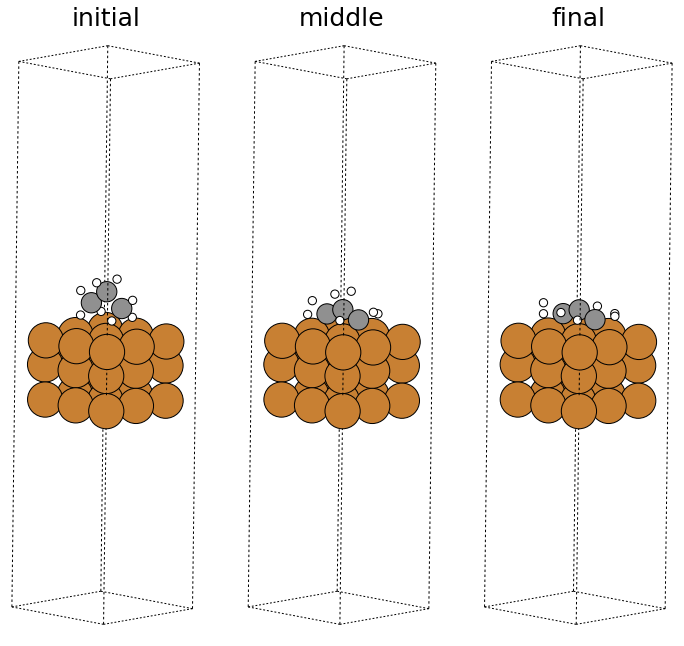

In [10]:
fig, ax = plt.subplots(1, 3)
labels = ['initial', 'middle', 'final']
for i in range(3):
    ax[i].axis('off')
    ax[i].set_title(labels[i])
ase.visualize.plot.plot_atoms(traj[0], ax[0], radii=0.8, rotation=("-75x, 45y, 10z"))
ase.visualize.plot.plot_atoms(traj[50], ax[1], radii=0.8, rotation=("-75x, 45y, 10z"))
ase.visualize.plot.plot_atoms(traj[-1], ax[2], radii=0.8, rotation=("-75x, 45y, 10z"))

### Saving a trajectory video

More visualization resources can be found here: https://wiki.fysik.dtu.dk/ase/ase/visualize/visualize.html.

MovieWriter ffmpeg unavailable; using Pillow instead.


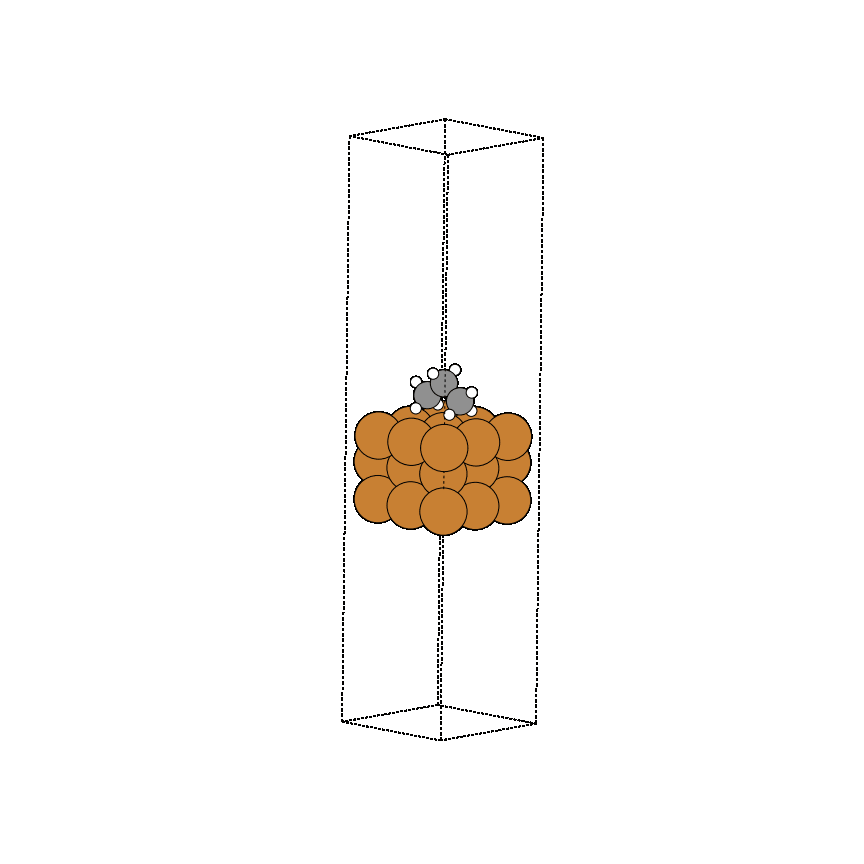

In [11]:
identifier = "toy_c3h8_relax.extxyz"
traj = ase.io.read("data/%s" % identifier, index=":")

ase.io.write(os.path.join(videos_dir, identifier + ".gif"),
             traj,
             interval=1,
             rotation=("-75x, 45y, 10z"))
plt.close()
Image(open(os.path.join(videos_dir, identifier + ".gif"),'rb').read())

In [12]:
import ffmpeg

ModuleNotFoundError: No module named 'ffmpeg'

### Data contents
Here we take a closer look at what information is contained within these trajectories.

In [ ]:
i_structure = traj[0]
i_structure

#### Atomic numbers

In [ ]:
numbers = i_structure.get_atomic_numbers()
print(numbers)

#### Atomic symbols

In [ ]:
symbols = np.array(i_structure.get_chemical_symbols())
print(symbols)

#### Unit cell

The unit cell is the volume containing our system of interest. Express as a 3x3 array representing the directional vectors that make up the volume. Illustrated as the dashed box in the above visuals.

In [ ]:
cell = np.array(i_structure.cell)
print(cell)

#### Periodic boundary conditions (PBC)

x,y,z boolean representing whether a unit cell repeats in the corresponding directions. The OC20 dataset sets this to [True, True, True], with a large enough vacuum layer above the surface such that a unit cell does not see itself in the z direction.

In [ ]:
pbc = i_structure.pbc
print(pbc)

#### Tags

The OC20 dataset consists of systems with several different types of atoms. To help with identifying the index of certain atoms, we tag each atom according to where it is found in the system - sub-surface slab atoms, surface slab atoms, and adsorbate atoms.

Tag:

0 - Sub-surface slab atoms <br>
1 - Surface slab atoms<br>
2 - Adsorbate atoms

In [ ]:
tags = i_structure.get_tags()
print(tags)

#### Fixed atoms constraint

In reality, surfaces contain many, many more atoms beneath what we've illustrated as the surface. At an infinite depth, these subsurface atoms would look just like the bulk structure. We approximate a true surface by fixing the subsurface atoms into their “bulk” locations. This ensures that they cannot move at the “bottom” of the surface. If they could, this would throw off our calculations. Consistent with the above, we fix all atoms with tags=0, and denote them as "fixed". All other atoms are considered "free". 

In [ ]:
cons = i_structure.constraints[0]
print(cons, '\n')

# indices of fixed atoms
indices = cons.index
print(indices, '\n')

# fixed atoms correspond to tags = 0
print(tags[indices])

#### Energy

The energy of the system is one of the properties of interest in the OC20 dataset. It's important to note that absolute energies provide little value to researchers and must be referenced properly to be useful. The OC20 dataset references all it's energies to the bare slab + gas references to arrive at adsorption energies. Adsorption energies are important in studying catalysts and their corresponding reaction rates. In addition to the structure realxations of the OC20 dataset, bare slab and gas (N2, H2, H2O, CO) relaxations were carried out with DFT in order to calculate adsorption energies.

In [ ]:
final_structure = traj[-1]
relaxed_energy = final_structure.get_potential_energy()
print(f'Relaxed absolute energy = {relaxed_energy} eV')

# Corresponding raw slab used in original adslab (adsorbate+slab) system. 
raw_slab = fcc100("Cu", size=(3, 3, 3))
raw_slab.set_calculator(EMT())
raw_slab_energy = raw_slab.get_potential_energy()
print(f'Raw slab energy = {raw_slab_energy} eV')


adsorbate = Atoms("C3H8").get_chemical_symbols()
# For clarity, we define arbitrary gas reference energies here.
# A more detailed discussion of these calculations can be found in the corresponding paper's SI. 
gas_reference_energies = {'H': .3, 'O': .45, 'C': .35, 'N': .50}

adsorbate_reference_energy = 0
for ads in adsorbate:
    adsorbate_reference_energy += gas_reference_energies[ads]

print(f'Adsorbte reference energy = {adsorbate_reference_energy} eV\n')

adsorption_energy = relaxed_energy - raw_slab_energy - adsorbate_reference_energy
print(f'Adsorption energy: {adsorption_energy} eV')

In [15]:
# Plot energy profile of toy trajectory
energies = [image.get_potential_energy() - raw_slab_energy - adsorbate_reference_energy for image in traj]

plt.figure(figsize=(7, 7))
plt.plot(range(len(energies)), energies, lw=3)
plt.xlabel("Step", fontsize=24)
plt.ylabel("Energy, eV", fontsize=24)

NameError: name 'raw_slab_energy' is not defined

#### Forces

Forces are another important property of the OC20 dataset. Unlike datasets like QM9 which contain only ground state properties, the OC20 dataset contains per-atom forces necessary to carry out atomistic simulations. Physically, forces are the negative gradient of energy w.r.t atomic positions: $F = -\frac{dE}{dx}$. Maintaining this energy-force consistency is important for models that seek to make predictions on both.

The "apply_constraint" argument controls whether to apply system constraints to the forces. In the OC20 dataset, this controls whether to return forces for fixed atoms (apply_constraint=False) or return 0s (apply_constraint=True).

In [16]:
# Returning forces for all atoms - regardless of whether "fixed" or "free"
i_structure.get_forces(apply_constraint=False)

array([[-1.07900000e-05, -3.80000000e-06,  1.13560540e-01],
       [ 0.00000000e+00, -4.29200000e-05,  1.13302410e-01],
       [ 1.07900000e-05, -3.80000000e-06,  1.13560540e-01],
       [-1.84600000e-05, -0.00000000e+00,  1.13543430e-01],
       [-0.00000000e+00, -0.00000000e+00,  1.13047800e-01],
       [ 1.84600000e-05,  0.00000000e+00,  1.13543430e-01],
       [-1.07900000e-05,  3.80000000e-06,  1.13560540e-01],
       [ 0.00000000e+00,  4.29200000e-05,  1.13302410e-01],
       [ 1.07900000e-05,  3.80000000e-06,  1.13560540e-01],
       [-1.10430500e-02, -2.53094000e-03, -4.84573700e-02],
       [ 1.10430500e-02, -2.53094000e-03, -4.84573700e-02],
       [-0.00000000e+00, -2.20890000e-04, -2.07827000e-03],
       [-1.10430500e-02,  2.53094000e-03, -4.84573700e-02],
       [ 1.10430500e-02,  2.53094000e-03, -4.84573700e-02],
       [-0.00000000e+00,  2.20890000e-04, -2.07827000e-03],
       [-3.49808000e-03, -0.00000000e+00, -7.85544000e-03],
       [ 3.49808000e-03, -0.00000000e+00

In [17]:
# Applying the fixed atoms constraint to the forces
i_structure.get_forces(apply_constraint=True)

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.31814437, -0.23642045, -0.39708923],
       [ 0.        , -2.18895316, -2.74768262],
       [ 0.31814437, -0.23642045, -0.397

### Resources

More helpful resources, tutorials, and documentation can be found at ASE's webpage: https://wiki.fysik.dtu.dk/ase/index.html. We point to specific pages that may be of interest:

- Interacting with Atoms Object: https://wiki.fysik.dtu.dk/ase/ase/atoms.html <br>
- Visualization: https://wiki.fysik.dtu.dk/ase/ase/visualize/visualize.html <br>
- Structure optimization: https://wiki.fysik.dtu.dk/ase/ase/optimize.html <br>
- Tutorials: https://wiki.fysik.dtu.dk/ase/tutorials/tutorials.html <br>

